In [1]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import seaborn as sns

import pandas as pd
import numpy as np
from random import choices
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer,balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [6]:
synthetic = pd.read_csv("synthetic.csv")
synthetic.pop('gender')
synthetic.head()

,admit,iq,sat
0,False,92.472816,959.728157
1,False,77.055728,862.557282
2,False,96.986655,1046.866552
3,False,104.129996,1105.299959
4,False,101.215587,1047.155871


In [7]:
synthetic['admit'] = [0 if x == False else 1 for x in synthetic['admit']]
# synthetic['gender'] = [0 if x == "woman" else 1 for x in synthetic['gender']]
synthetic.describe()

,admit,iq,sat
count,5000.000000,5000.000000,5000.000000
mean,0.404000,100.037458,1045.088979
std,0.490747,19.909603,201.439475
min,0.000000,23.912771,271.127706
25%,0.000000,86.664101,908.881888
50%,0.000000,99.936357,1040.152307
75%,1.000000,113.993465,1185.707223
max,1.000000,159.906606,1688.765366


In [8]:
counts = synthetic['admit'].value_counts().to_dict()
print(counts)
MCPc = counts[1]/(counts[0]+counts[0])*100
print("Percent of positive labels (Y = 1): {0:.2f}%".format(MCPc))

{0: 2980, 1: 2020}
Percent of positive labels (Y = 1): 33.89%


In [9]:
def add_Fx(df_p,df_n,ppc, npc):
    """
    
    Add sensitive feature {0,1} to the dataframe
    
    parameter:
    - df_p   : dataframe for Y = 1
    - df_n   : dataframe for Y = 0
    - ppc    : percentage of S = 1 in Y = 0
    - npc    : percentage of S = 1 in Y = 0
    
    output:
    - X      : 8-dim array of independent variable
    - y      : 1-dim array of target variable
    
    """
    
    
    df_p.loc[:, 'Feature_X'] = choices([0,1],cum_weights = [ppc,100], k = len(df_p))
    df_n.loc[:, 'Feature_X'] = choices([0,1],cum_weights = [npc,100], k = len(df_n))
    dall = df_p.append(df_n)   
    
#     print("Distribution of Sensitive Attribute in Y = 1: {}".format(Counter(df_p['Feature_X'])))
#     print("Distribution of Sensitive Attribute in Y = 0: {}".format(Counter(df_n['Feature_X'])))
#     print("Distribution of Y (total): {}".format(Counter(dall['Class'])))
#     print("Distribution of Sensitive Attribute in Y (total): {}".format(Counter(dall['Feature_X'])))
    y = dall.pop("admit").values
    X = dall.values
    #print("Dimension of X after adding sensitive attribute: {}".format(X.shape))
    #print("Shape of y: {}".format(y.shape))
    return X, y 

def df_subsample_pos_class(all_df, rpc = 0, subsample = True):
    
    """
    
    Add sensitive feature {0,1} to the dataframe
    
    parameter:
    - all_df : original dataframe
    - rpc    : requested positive percentage to subsample
    
    output:
    - df_p      : dataframe for Y = 1 after subsampling
    - df_n      : dataframe for Y = 0
    
    """
    
    if subsample :
        rp = rpc/100 
        df_p = all_df[all_df['admit']==1].copy()
        df_n = all_df[all_df['admit']==0].copy()
        np = len(df_p)
        nn = len(df_n)
        perc_p = np/(np+nn)
    
        if rp > perc_p:
            print('Requested positive percentage (pcpc) is too high.',perc_p)
            return df_p, df_n
    
        np_dash = rp/(1-rp)* nn
        df_p = df_p.sample(int(np_dash+0.5))
    
        #print(np,nn,'--',np_dash)
        return df_p, df_n
    else:
        df_p = all_df[all_df['admit']==1].copy()
        df_n = all_df[all_df['admit']==0].copy()
        return df_p,df_n
    
def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    Bias_FX0 = P_dash_FX0/P_FX0
    
    if P_FX0 == 0:
        print("Divsion by zero detected!")
               
    return Bias_FX0

def evaluate_model(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted labels
    - y_prob : predicted probability
    - SA     : sensitive attributes in the test data
    
    output:
    - accuracy : accuracy scores
    - rocauc   : roc auc scores
    - us_0     : underestimation score for S = 0
    - us_1     : underestimation score for S = 1
    
    """
    accuracy = balanced_accuracy_score(y_true,y_pred)
    b = underestimation_score(y_true,y_pred,SA)
    return accuracy,b


    
def preprocess_data(X,y):
    """
    Numerical features are scaled using MinMaxScaler, while categorical features one-hot-encoded.
    
    parameter:
    - X    : 8-dim array of independent variable
    - y    : 1-dim array of target variable
    
    output:
    - Xtrain      : 8-dim array containing independent variable in the train test
    - Xtest       : 8-dim array containing independent variable in the test set
    - y_train     : 1-dim array of target variable in the train set
    - y_test      : 1-dim array of target variable in the test set
    
    """
    
    minority_in_Pos = 0
    
    while not minority_in_Pos:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, stratify = y)
        temp = pd.DataFrame({'Feature_X': X_test[:,2], 'admit': y_test}, columns=['Feature_X', 'admit'])
#         print(df_count_feat_val_match(temp, 'admit', 1, 'Feature_X',0) )
        minority_in_Pos = df_count_feat_val_match(temp, 'admit', 1, 'Feature_X',0)    

    minmax = MinMaxScaler()
    xtrain_num = minmax.fit_transform(X_train[:,0:2])
    xtest_num = minmax.transform(X_test[:,0:2])
    
    Xtrain = np.hstack((xtrain_num,X_train[:,2].reshape(-1,1)))
    Xtest = np.hstack((xtest_num,X_test[:,2].reshape(-1,1)))

#     print("Shape of train data: {}".format(Xtrain.shape))
#     print("Shape of test data : {}".format(Xtest.shape))
    
    return Xtrain,Xtest,y_train,y_test

### Logistic Regression

In [10]:
logreg_param = [0.001,0.01,0.1,1,10,100,1000]
logreg_param.reverse()
logreg_DF = pd.DataFrame(columns=['Balanced Accuracy','Underestimation'])


for c in logreg_param:
    print("C: {}".format(c))
    logreg =  LogisticRegression(C=c,max_iter=1000,n_jobs=-1,random_state=0) 
    accuracies_mean, bias_mean = [],[]

    
    for i in range(20):
        df_p,df_n = df_subsample_pos_class(synthetic,subsample=False)
        X,y = add_Fx(df_p,df_n,50,50)
        Xtrain,Xtest,y_train,y_test = preprocess_data(X,y)
        logreg.fit(Xtrain,y_train)
        y_pred = logreg.predict(Xtest)
        acc,bias = evaluate_model(y_test,y_pred,Xtest[:,2].ravel())
        accuracies_mean.append(acc)
        bias_mean.append(bias)
    logreg_DF.loc[str(c)] = [np.median(accuracies_mean),np.median(bias_mean)] 

C: 1000
C: 100
C: 10
C: 1
C: 0.1
C: 0.01
C: 0.001


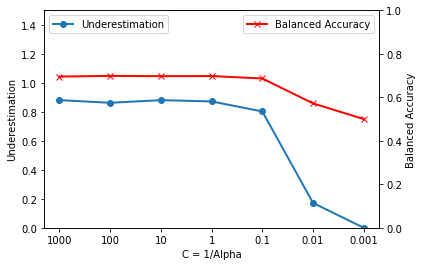

In [12]:
ax1=logreg_DF['Underestimation'].plot(linewidth=2.0, marker = 'o')
ax2=logreg_DF['Balanced Accuracy'].plot(secondary_y=True, color = 'r',marker = 'x',linewidth=2.0)

ax1.set_ylim(0,1.5)
ax2.set_ylim(0,1)
ax1.set_xlabel('C = 1/Alpha')
ax2.set_ylabel('Balanced Accuracy',  fontsize = 10)
ax1.set_ylabel('Underestimation',  fontsize = 10)
ax1.legend(loc="upper left", ncol = 2, fontsize = 10)
ax2.legend(loc="upper right", fontsize = 10)
plt.savefig('LR.png', dpi = 300,bbox_inches = 'tight')
plt.show()

### Neural Networks

In [13]:
NN_param = [0.1,1,2,5,7,10,12]
NN_DF = pd.DataFrame(columns=['Balanced Accuracy','Underestimation'])


for a in NN_param:
    print("Alpha: {}".format(a))
    NN =  MLPClassifier(hidden_layer_sizes=[50], max_iter=1000, alpha = a)
    accuracies_mean, bias_mean = [],[]
    for i in range(20):
        df_p,df_n = df_subsample_pos_class(synthetic,subsample=False)
        X,y = add_Fx(df_p,df_n,15,30)
        Xtrain,Xtest,y_train,y_test = preprocess_data(X,y)
        NN.fit(Xtrain,y_train)
        y_pred = NN.predict(Xtest)
        acc,bias = evaluate_model(y_test,y_pred,Xtest[:,2].ravel())
        accuracies_mean.append(acc)
        bias_mean.append(bias)
    NN_DF.loc[str(a)] = [np.median(accuracies_mean),np.median(bias_mean)] 

Alpha: 0.1
Alpha: 1
Alpha: 2
Alpha: 5
Alpha: 7
Alpha: 10
Alpha: 12


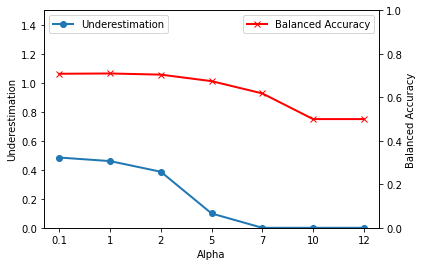

In [14]:
ax1=NN_DF['Underestimation'].plot(linewidth=2.0, marker = 'o')
ax2=NN_DF['Balanced Accuracy'].plot(secondary_y=True, color = 'r',marker = 'x',linewidth=2.0)

ax1.set_ylim(0,1.5)
ax2.set_ylim(0,1)
ax1.set_xlabel('Alpha')
ax2.set_ylabel('Balanced Accuracy',  fontsize = 10)
ax1.set_ylabel('Underestimation',  fontsize = 10)
ax1.legend(loc="upper left", ncol = 2, fontsize = 10)
ax2.legend(loc="upper right", fontsize = 10)
plt.savefig('NN.png', dpi = 300,bbox_inches = 'tight')
plt.show()

### Decision Tree

In [15]:
DT_param =  [2,3,5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,300]
DT_DF = pd.DataFrame(columns=['Balanced Accuracy','Underestimation'])


for depth in DT_param:
    print("max_depth: {}".format(depth))
    DT =  DecisionTreeClassifier(min_samples_split=depth)
    accuracies_mean, bias_mean = [],[]
    for i in range(20):
        df_p,df_n = df_subsample_pos_class(synthetic,subsample=False)
        X,y = add_Fx(df_p,df_n,15,30)
        Xtrain,Xtest,y_train,y_test = preprocess_data(X,y)
        DT.fit(Xtrain,y_train)
        y_pred = DT.predict(Xtest)
        acc,bias = evaluate_model(y_test,y_pred,Xtest[:,2].ravel())
        accuracies_mean.append(acc)
        bias_mean.append(bias)
    DT_DF.loc[str(depth)] = [np.median(accuracies_mean),np.median(bias_mean)] 

max_depth: 2
max_depth: 3
max_depth: 5
max_depth: 10
max_depth: 20
max_depth: 30
max_depth: 40
max_depth: 50
max_depth: 60
max_depth: 70
max_depth: 80
max_depth: 90
max_depth: 100
max_depth: 110
max_depth: 120
max_depth: 130
max_depth: 140
max_depth: 150
max_depth: 160
max_depth: 170
max_depth: 180
max_depth: 190
max_depth: 200
max_depth: 300


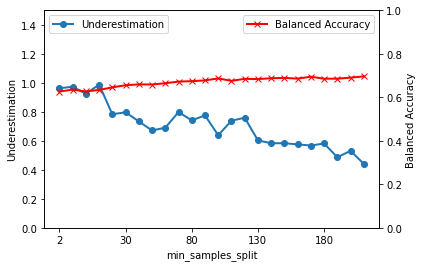

In [16]:
ax1=DT_DF['Underestimation'].plot(linewidth=2.0, marker = 'o')
ax2=DT_DF['Balanced Accuracy'].plot(secondary_y=True, color = 'r',marker = 'x',linewidth=2.0)

ax1.set_ylim(0,1.5)
ax2.set_ylim(0,1)
ax1.set_xlabel('min_samples_split')
ax2.set_ylabel('Balanced Accuracy',  fontsize = 10)
ax1.set_ylabel('Underestimation',  fontsize = 10)
ax1.legend(loc="upper left", ncol = 2, fontsize = 10)
ax2.legend(loc="upper right", fontsize = 10)
plt.savefig('DT.png', dpi = 300,bbox_inches = 'tight')
plt.show()

### Gradient Boosting

In [17]:
GBDT_param =  [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
GBDT_param.reverse()
GBDT_DF = pd.DataFrame(columns=['Balanced Accuracy','Underestimation','TPR','TNR'])


for n in GBDT_param:
    print("n_estimators: {}".format(n))
    GBDT =  GradientBoostingClassifier(learning_rate = 0.1, n_estimators=n,max_depth=1)
    accuracies_mean, bias_mean = [],[]
    tpr_mean,tnr_mean = [],[]
    for i in range(20):
        df_p,df_n = df_subsample_pos_class(synthetic,subsample=False)
        X,y = add_Fx(df_p,df_n,15,30)
        Xtrain,Xtest,y_train,y_test = preprocess_data(X,y)
        GBDT.fit(Xtrain,y_train)
        y_pred = GBDT.predict(Xtest)
        acc,bias = evaluate_model(y_test,y_pred,Xtest[:,2].ravel())
        accuracies_mean.append(acc)
        bias_mean.append(bias)
        #print(tn,fp,fn,tp)
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        tpr = tp/(tp+fn)
        tnr = tn/(tn+fp)
        tpr_mean.append(tpr)
        tnr_mean.append(tnr)
    GBDT_DF.loc[str(n)] = [np.median(accuracies_mean),np.median(bias_mean),np.median(tpr_mean),np.median(tnr_mean)] 

n_estimators: 20
n_estimators: 19
n_estimators: 18
n_estimators: 17
n_estimators: 16
n_estimators: 15
n_estimators: 14
n_estimators: 13
n_estimators: 12
n_estimators: 11
n_estimators: 10
n_estimators: 9
n_estimators: 8
n_estimators: 7
n_estimators: 6
n_estimators: 5
n_estimators: 4
n_estimators: 3
n_estimators: 2
n_estimators: 1


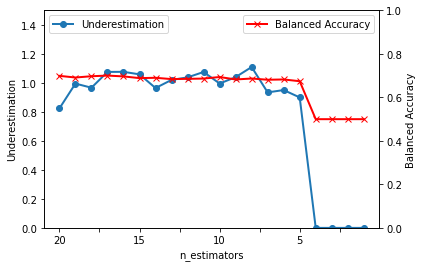

In [18]:
ax1=GBDT_DF['Underestimation'].plot(linewidth=2.0, marker = 'o')
ax2=GBDT_DF['Balanced Accuracy'].plot(secondary_y=True, color = 'r',marker = 'x',linewidth=2.0)


ax1.set_ylim(0,1.5)
ax2.set_ylim(0,1)
ax1.set_xlabel('n_estimators')
ax2.set_ylabel('Balanced Accuracy',  fontsize = 10)
ax1.set_ylabel('Underestimation',  fontsize = 10)
ax1.legend(loc="upper left", ncol = 2, fontsize = 10)
ax2.legend(loc="upper right", fontsize = 10)
plt.savefig('GDBT.png', dpi = 300,bbox_inches = 'tight')
plt.show()

In [ ]:
GBDT_DF